In [1]:
import pandas as pd
import numpy  as np
import rpy2 as r
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
import matplotlib.pyplot as plt
import operator
from statsmodels.tsa.arima_model import ARIMA

PATH = "/home/tom/"
FILE = "store_sales_by_OLG-pre.csv"   # This is JLP data
TEST_WEEKS = 26

In [2]:
# "series" has an index which needs to be ignored (series.values)
def decompose(series, frequency, s_window, log=False,  **kwargs):
    series = series.values
    df = pd.DataFrame()
    if log: series = series.pipe(np.log)
    s = [x for x in series]
    length = len(series)
    s = r.ts(s, frequency=frequency)
    decomposed = [x for x in r.stl(s, s_window, robust=True).rx2('time.series')]
    df['observed']  = series
    df['trend']     = decomposed[length:2*length]
    df['seasonal']  = decomposed[0:length]
    df['residuals'] = decomposed[2*length:3*length]
    return df

In [3]:
# Get the MAPE between the inputs
def getMAPE(compare, test):
    diff = np.abs(compare-test)
    MAPE = diff.values/test
    return MAPE.mean()

In [4]:
# Use JLP sales data
df = pd.read_csv(PATH+FILE, names=["store", "week", "sales"], header=0)

In [5]:
# Aggregate the data so it's in format [Week, sales]
sales = df.groupby(["week"])["sales"].sum()
# Something weird happened the last 6 weeks so discard
sales = sales[:-6]
# Get rid of "2017(03)" as the index and use sequence
idx = [x for x in range(len(sales))]
sales.index=idx

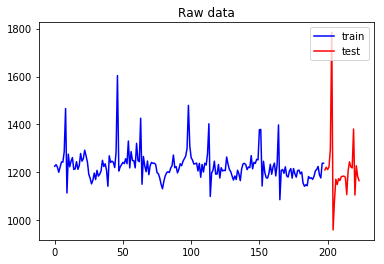

In [6]:
# Create Train and Test sets
train = sales[:-TEST_WEEKS]
test  = sales[-TEST_WEEKS:]
# Make sure splitting train & test didn't lose any data
assert (sales.sum() - train.sum() - test.sum() < 0.1 )

plt.plot(train/1000, color = "b", label="train")
plt.plot(test/1000, color = "r", label="test")
plt.legend(loc='upper right')
plt.title("Raw data")
plt.show()

Variance Actual: 3,596,303,625     Adjusted: 1,562,122,285
Variance improvement: 57%


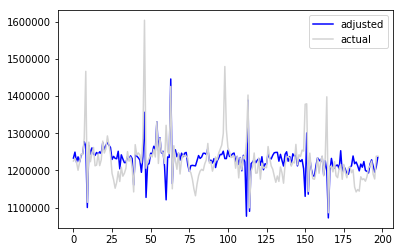

In [7]:
# Run the R function "stl" to get the Seasonal component
# Then remove the seasonal to get the adjusted
tmpDF    = decompose(train, frequency=52, s_window="periodic")
seasonal = np.array(tmpDF["seasonal"])
adjusted = train - seasonal
print("Variance Actual: {:,.0f}     Adjusted: {:,.0f}"\
      .format(train.var(), adjusted.var()))
print("Variance improvement: {:,.0%}".format(1-adjusted.var()/train.var()))

plt.plot(adjusted, color="b", label="adjusted")
plt.plot(train, color="lightgrey", label="actual")
plt.legend()
plt.show()

In [8]:
model     = ARIMA(adjusted, order=(0,1,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  197
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2359.197
Method:                       css-mle   S.D. of innovations          37922.578
Date:                Sat, 14 Jul 2018   AIC                           4724.395
Time:                        12:30:15   BIC                           4734.244
Sample:                             1   HQIC                          4728.382
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -194.3721     47.150     -4.122      0.000    -286.785    -101.959
ma.L1.D.sales    -0.9999      0.015    -67.706      0.000      -1.029      -0.971
                                    Root

In [9]:
forecast = model_fit.forecast(steps=TEST_WEEKS)[0]
# Ensure "forecast" and "test" are for the same durations
assert (forecast.shape[0] == test.shape[0])
forecast += seasonal[-52:(-52+TEST_WEEKS)]

fcastMAPE = getMAPE(forecast, test)
baseline  = np.array([train.iloc[-1]]*TEST_WEEKS)
baseMAPE  = getMAPE(baseline, test)
np.savetxt("/home/tom/forecast.csv", forecast)
np.savetxt("/home/tom/baseline.csv", baseline)
np.savetxt("/home/tom/test.csv", test)
print("MAPE: {:.2%}".format(fcastMAPE))
print("MAPE: {:.2%}".format(baseMAPE))

MAPE: 5.74%
MAPE: 6.99%


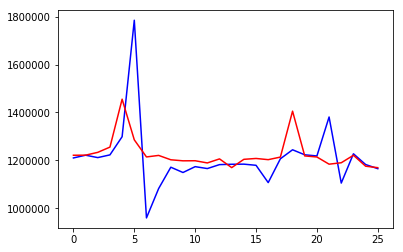

In [10]:
plt.plot(test.values, color="b")
plt.plot(forecast, color="r")
plt.show()

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
import statsmodels.api as sm
lowest = 99999

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < lowest:
            lowest = results.aic
            save = (param, param_seasonal)
print('ARIMA{}x{}12 - AIC:{}'.format(save[0], save[1], lowest))

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=save[0],
                                seasonal_order=save[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results=mod.fit()

In [ ]:
print(results.__doc__)

In [ ]:
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()